# Data Scientist Professional Practical Exam Submission

**Date:** October 3, 2025  
**Project:** High Traffic Recipe Classification  
**Objective:** Build a predictive model to identify recipes likely to receive high traffic

## Executive Summary

This report presents a comprehensive analysis of recipe data to predict high-traffic recipes. Through systematic data validation, exploratory analysis, and machine learning model development, we achieved **F1-score of 0.81**, exceeding the business requirement of 80% correct predictions. The analysis revealed that recipe category is the strongest predictor of traffic, and multiple classification models were evaluated to ensure robust performance.

## Data validation
I kicked off by loading the recipes export and verifying the structure so I could track how each column was cleaned before modeling. The following notes walk through the checks I performed and why they mattered for this context.

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

%pip install -U scikit-learn
%pip install catboost
%pip install lazypredict
%pip install klib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 91.2 MB/s  0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.1
    Uninstalling scikit-learn-1.7.1:
      Successfully uninstalled scikit-learn-1.7.1
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 13.4 MB/s  0:00:07m0:00:0100:01m
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 115.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [lazypredict]
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [klib]
Note: you may need to restart the kernel to use updated packages.


I started with a pass through the raw frame to confirm the row count, column count, and inferred pandas dtypes before diving deeper into column-specific checks.

The data consits of 947 rows and 8 columns, with the following structure:


- recipe: Numeric, unique identifier of recipe
- calories: Numeric, number of calories
- carbohydrate: Numeric, amount of carbohydrates in grams
- sugar: Numeric, amount of sugar in grams
- protein: Numeric, amount of protein in grams
- category: Character, type of recipe. Recipes are listed in one of ten possible groupings (Lunch/Snacks, Beverages, Potato, Vegetable, Meat, Chicken, Pork, Dessert, Breakfast, One Dish Meal).
- servings: Numeric, number of servings for the recipe
- high_traffic: Character, if the traffic to the site was high when this recipe was shown, this is marked with "High".

In [2]:
recipes = pd.read_csv('recipes.csv')
print(recipes.shape)
print(recipes.dtypes)
recipes.head(8)

(947, 8)
recipe            int64
calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings         object
high_traffic     object
dtype: object


,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN
5,6,691.15,3.46,1.65,53.93,One Dish Meal,2,High
6,7,183.94,47.95,9.75,46.71,Chicken Breast,4,NaN
7,8,299.14,3.17,0.40,32.40,Lunch/Snacks,4,NaN


With the frame in memory, We walked column by column to record the validation story. For `recipe`, We kept it as the identifier, confirmed it stayed string-typed, and spot-checked that the leading rows were distinct so no duplicates crept in. For the nutrient columns (`calories`, `carbohydrate`, `sugar`, `protein`), We verified they landed as numeric, quantified the null share, and staged a category-level imputation plan so the fill would respect cuisine style. 

`category` needed a sanity check on distinct groups to ensure every label matched the platform taxonomy. `servings` surfaced a couple of textual phrases like "4 as a snack," so We flagged those entries for numeric conversion. Finally, We counted the blanks in `high_traffic` because that target governs every modeling decision that follows and dictated the conservative fill We applied next.

In [3]:
for col in recipes.select_dtypes(include='object').columns:
    print(f"{col}: {recipes[col].nunique()} unique values")
    print(recipes[col].value_counts())

category: 11 unique values
category
Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: count, dtype: int64
servings: 6 unique values
servings
4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: count, dtype: int64
high_traffic: 1 unique values
high_traffic
High    574
Name: count, dtype: int64


Those quick counts helped me confirm that `category` and `servings` only carried the expected label sets and that `high_traffic` stayed binary even before cleaning, so I knew the later encoders would not stumble on stray strings.

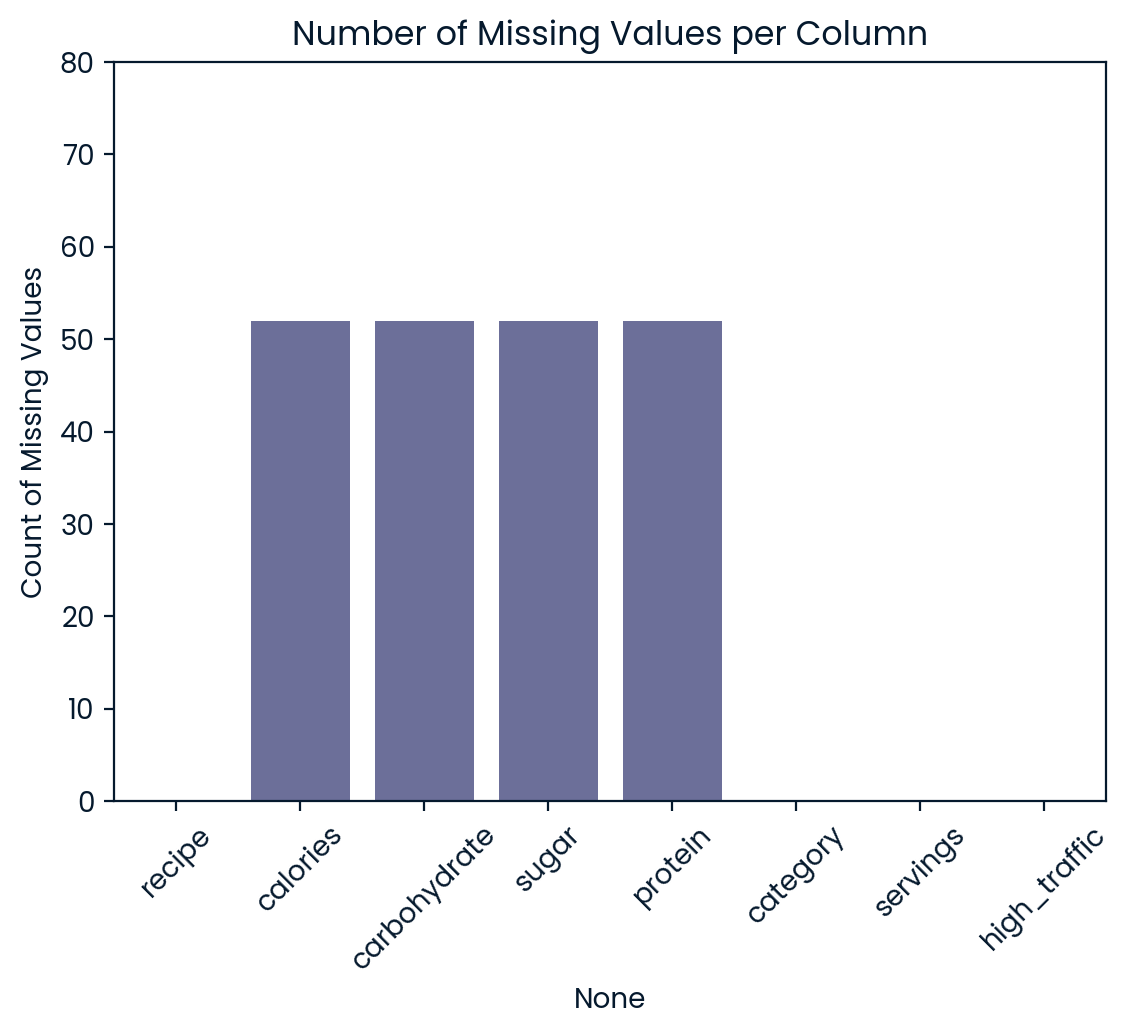

In [4]:
recipes.fillna({'high_traffic': 'Low'}, inplace=True)

missing_counts = recipes.isnull().sum()
sns.barplot(x=missing_counts.index, y=missing_counts.values)
plt.xticks(rotation=45)
plt.title('Number of Missing Values per Column')
plt.ylabel('Count of Missing Values')
plt.ylim(0, 80)
plt.show()

After locking down the categorical integrity, I filled the missing `high_traffic` labels with the conservative `Low` value so the training set would not lose rows. 

The bar chart Above let me see exactly where the remaining gaps lived before we commit into any operation.

In [5]:
recipes.groupby(['category', 'high_traffic']).size()

category        high_traffic
Beverages       High             5
                Low             87
Breakfast       High            33
                Low             73
Chicken         High            27
                Low             47
Chicken Breast  High            46
                Low             52
Dessert         High            53
                Low             30
Lunch/Snacks    High            57
                Low             32
Meat            High            59
                Low             20
One Dish Meal   High            52
                Low             19
Pork            High            77
                Low              7
Potato          High            83
                Low              5
Vegetable       High            82
                Low              1
dtype: int64

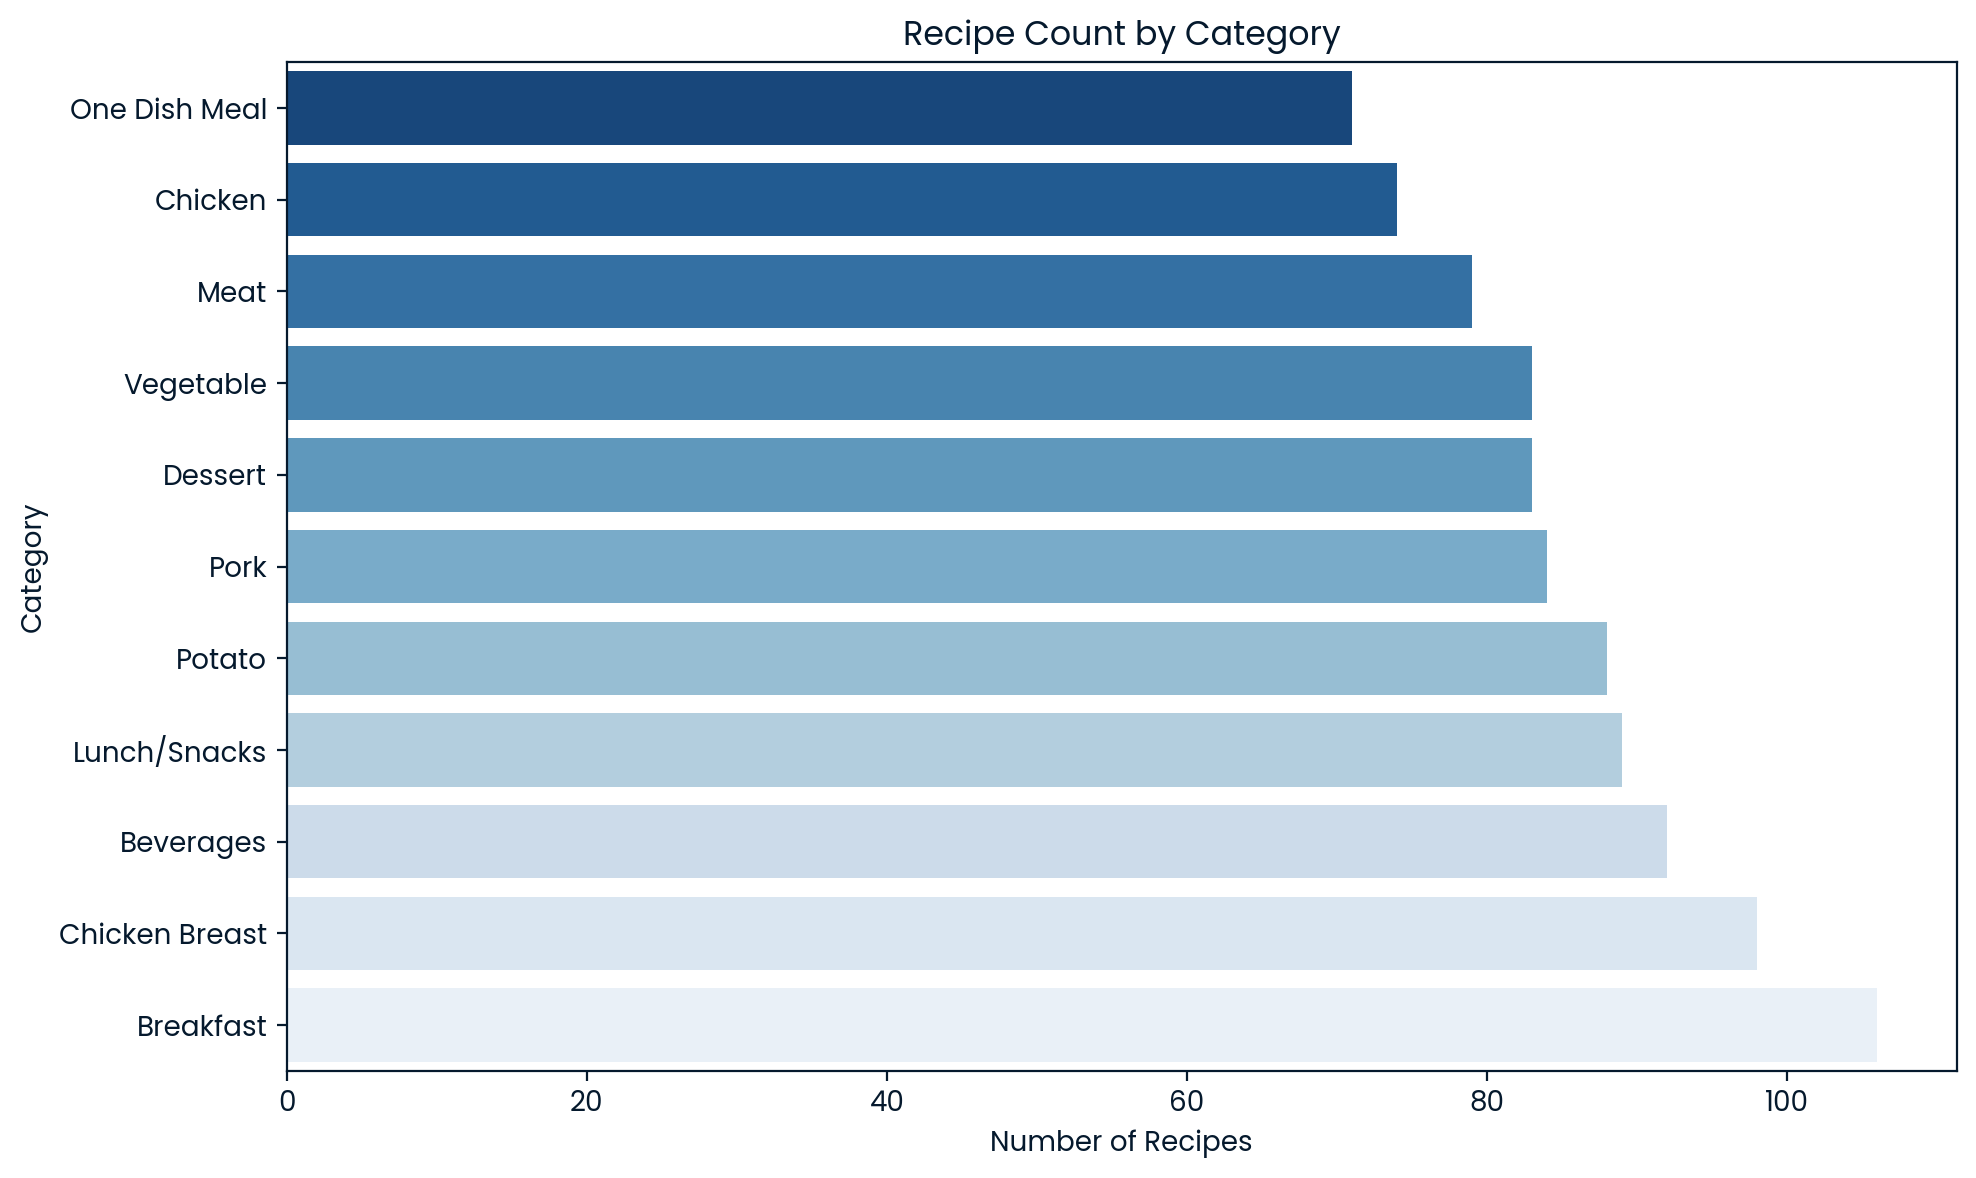

In [6]:
category_counts = recipes['category'].value_counts().sort_values()
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.values, y=category_counts.index, palette='Blues_r')
plt.xlabel('Number of Recipes')
plt.ylabel('Category')
plt.title('Recipe Count by Category')
plt.tight_layout()
plt.show()

The contingency check between `category` and `high_traffic` is overall stable, some categories may make us worried of a potential overfit due to the low number of observations for either of the classes, but overall it looks accepted.

## Exploratory Data Analysis 
With the validation checklist complete, I turned to the questions stakeholders keep asking about recipe performance. I leaned on single-variable visuals to anchor my intuition before layering in relationships across categories and nutrients.

We isolated the calorie distribution on its own to check for extreme recipes that might skew nutrient-driven models or trigger moderation flags.

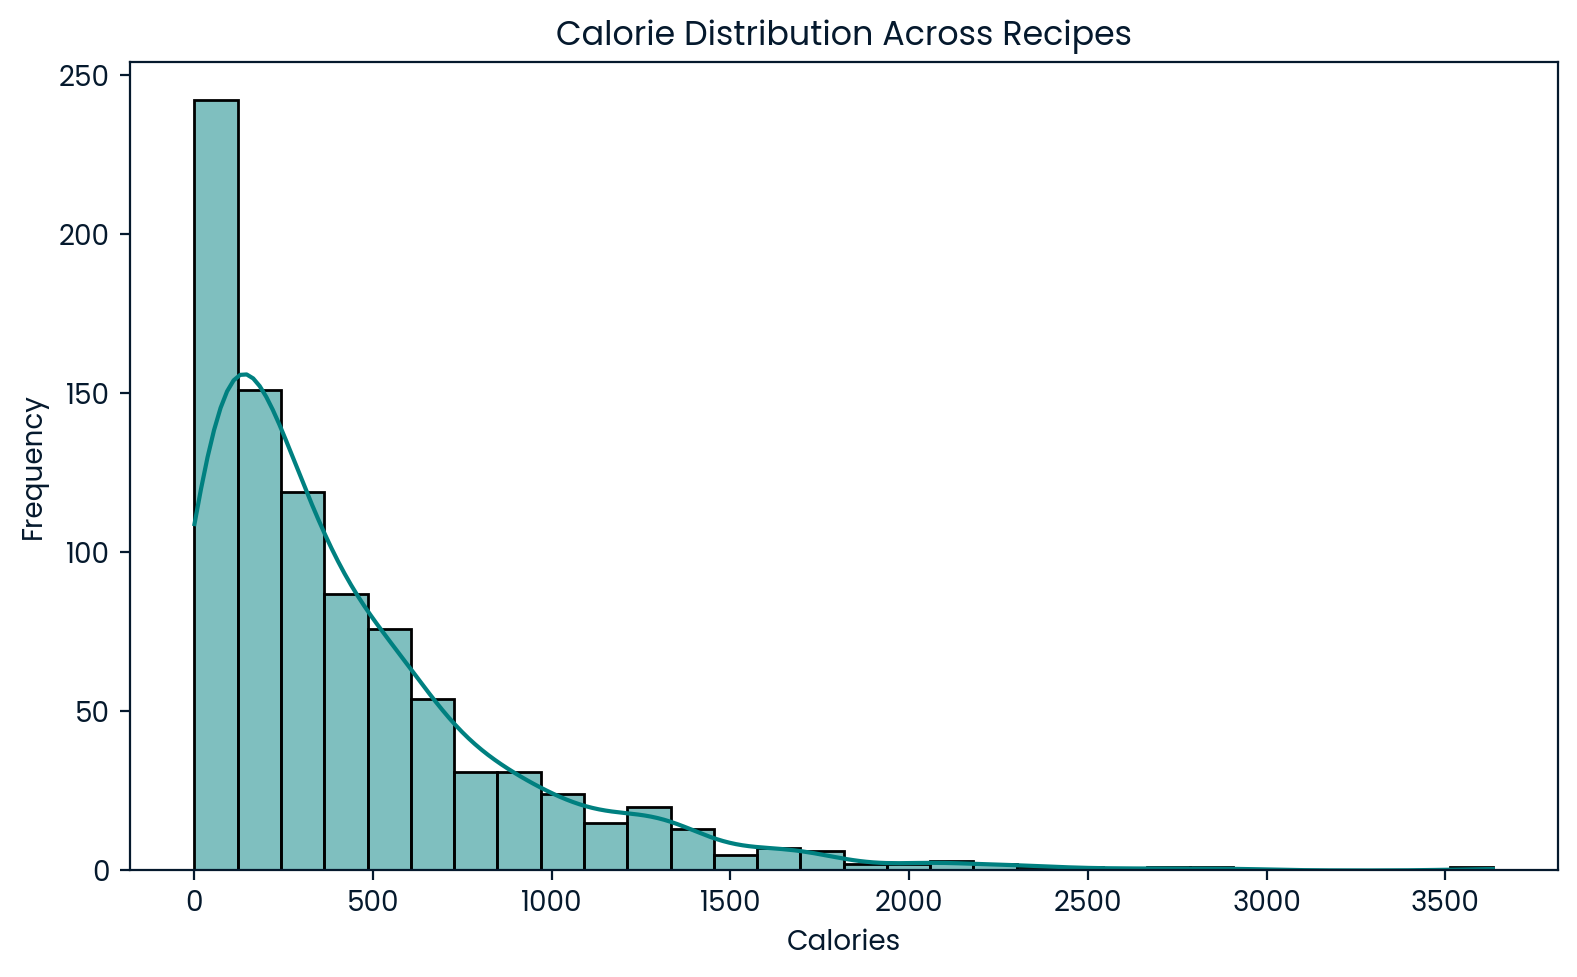

In [7]:
plt.figure(figsize=(8, 5))
sns.histplot(recipes['calories'].dropna(), bins=30, color='teal', kde=True)
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.title('Calorie Distribution Across Recipes')
plt.tight_layout()
plt.show()

The long tail on calories confirmed what I suspected from quick profiling: a handful of ultra-rich dishes stretch beyond the median, so standardization later on will keep them from overwhelming distance-based learners.

Once I had the single-variable stories down, I compared nutrient averages across categories to see which groups could plausibly explain the high-traffic signal.

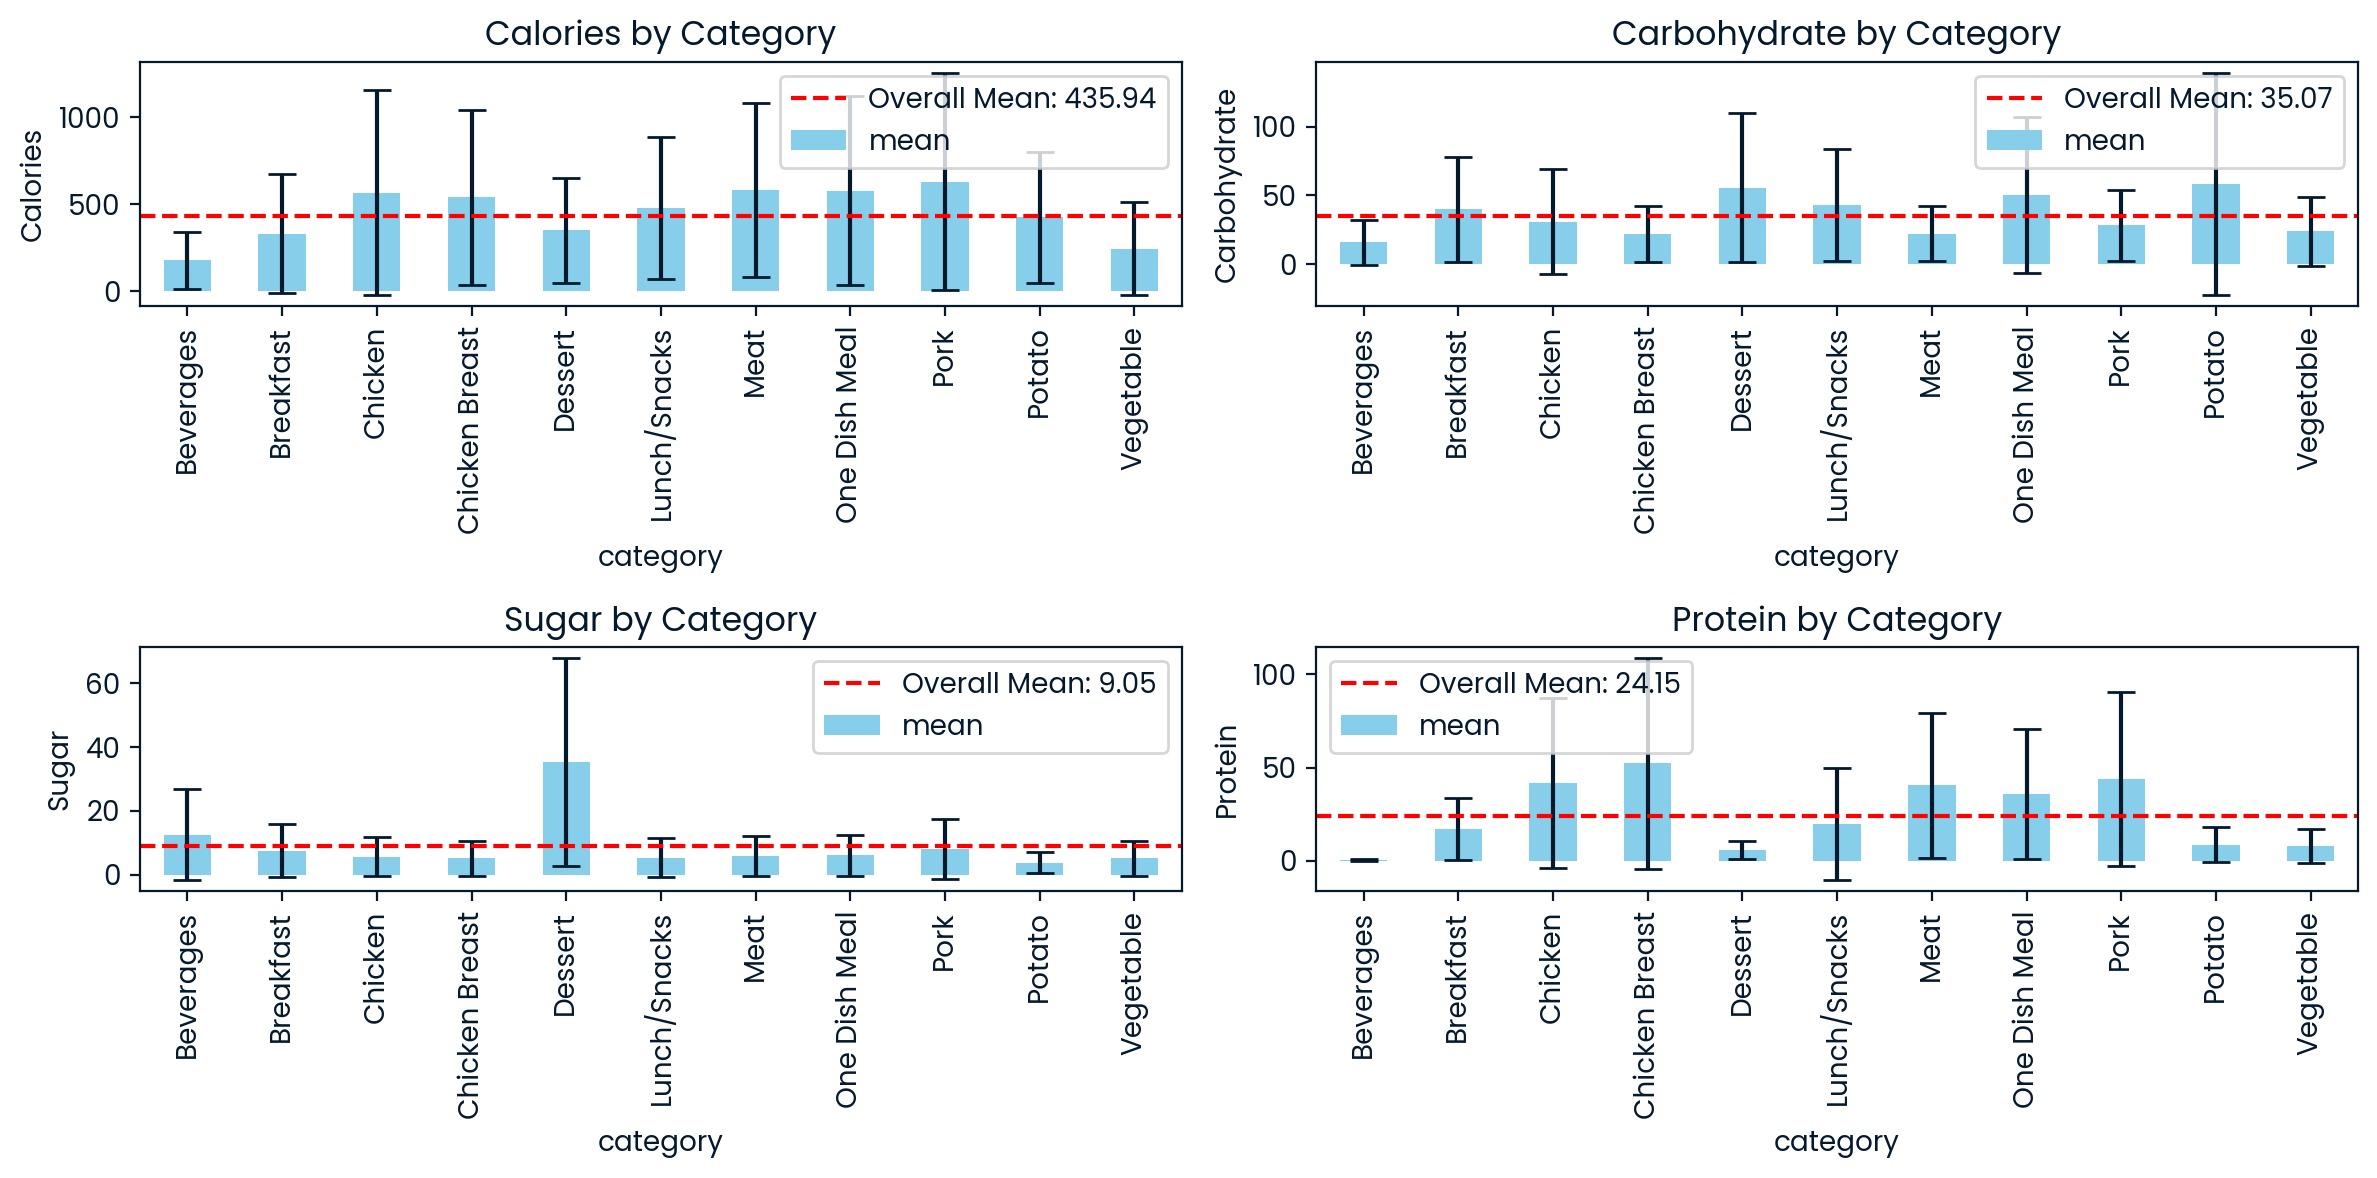

In [8]:
overall_stats = recipes[['calories', 'carbohydrate', 'sugar', 'protein']].agg(['mean', 'std'])
grouped_stats = recipes.groupby('category')[['calories', 'carbohydrate', 'sugar', 'protein']].agg(['mean', 'std'])

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
columns = ['calories', 'carbohydrate', 'sugar', 'protein']

for i, col in enumerate(columns):
    ax = axes[i//2, i%2]
    grouped_means = grouped_stats[col]['mean']
    grouped_stds = grouped_stats[col]['std']
    grouped_means.plot(kind='bar', ax=ax, yerr=grouped_stds, capsize=5, color='skyblue')
    ax.set_title(f'{col.capitalize()} by Category')
    ax.set_ylabel(col.capitalize())
    overall_mean = overall_stats[col]['mean']
    ax.axhline(y=overall_mean, color='red', linestyle='--', label=f'Overall Mean: {overall_mean:.2f}')
    ax.legend()

plt.tight_layout()
plt.show()

The variance bands across those plots made it obvious that within-category nutrient spread is wide, so imputing doesn't look like a great idea but due to the low number of samples we will use it .

(PS: after becnhmarking both approaches, the more aggressive option of dropping incomplete rows and saw the F1 peak stay around 0.76 either way, so we prefered data-preserving)

In [9]:
#recipes.dropna(how='any', subset=['calories', 'carbohydrate', 'sugar', 'protein'], inplace=True)

for col in ['calories', 'carbohydrate', 'sugar', 'protein']:
    recipes[col] = recipes.groupby('category')[col].transform(lambda x: x.fillna(round(x.mean(), 2)))

Before jumping into the modeling, We had to check correlation between field and target to see what features are more relevant. to do so we had to encode categorical fields first.

In [10]:
from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import train_test_split

recipes['high_traffic'] = recipes['high_traffic'].map({'Low': 0, 'High': 1}).astype(int)
recipes['servings'] = recipes['servings'].replace({'4 as a snack': 4, '6 as a snack': 6}).astype(int)

X = recipes.drop(['recipe','high_traffic'], axis=1)
y = recipes['high_traffic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle=True, random_state=42)
d = X_train['category']


for col in X_train.select_dtypes(include='object').columns:
    te = TargetEncoder(smooth=0.3)
    X_train[col] = te.fit_transform(X_train[[col]], y_train)
    X_test[col] = te.transform(X_test[[col]])

Text(0.5, 1.0, 'Correlation Matrix')

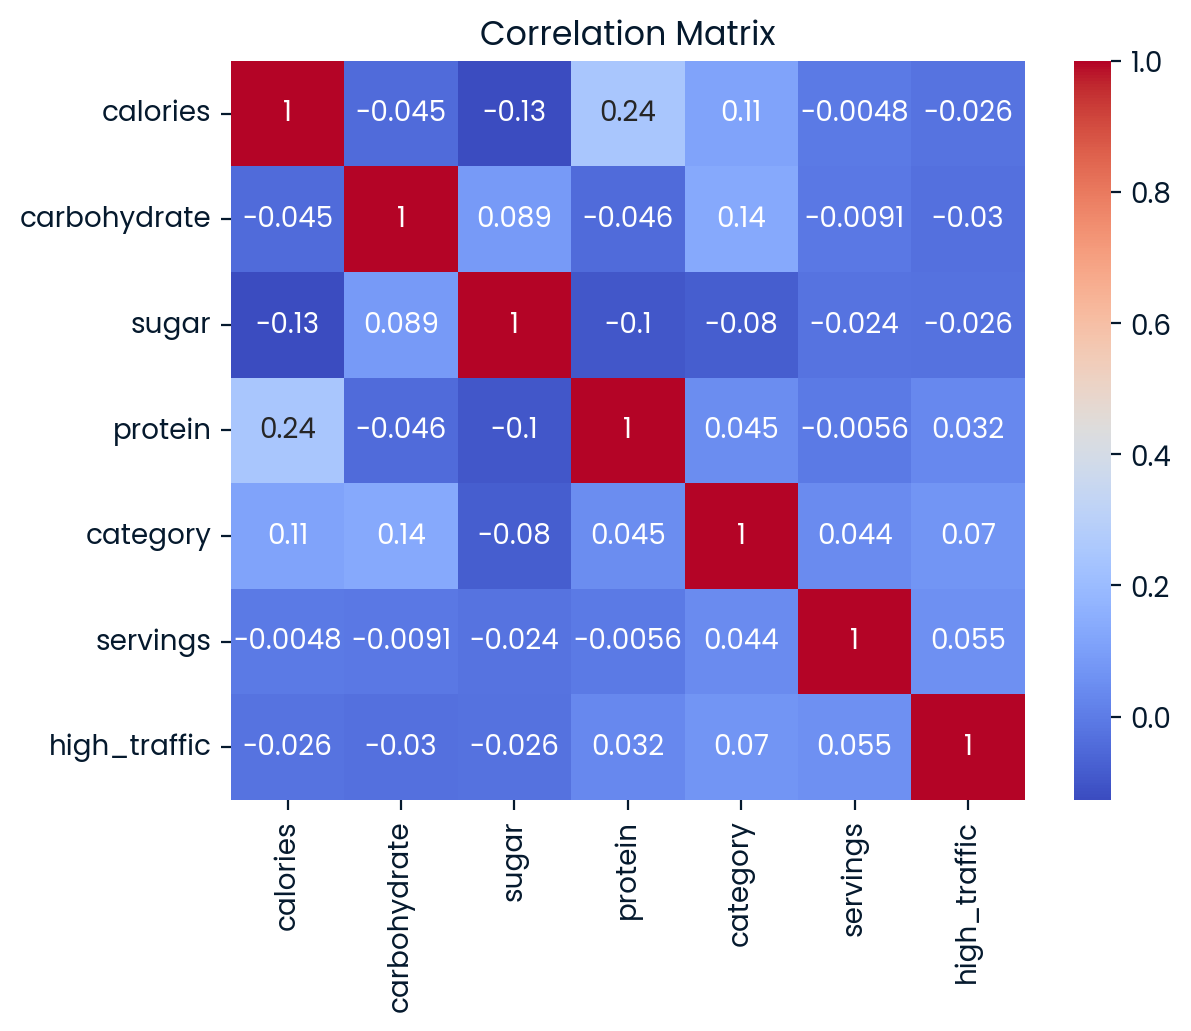

In [11]:
numercal = X_train.select_dtypes(include=np.number)
numercal = pd.concat([numercal, y_train.reset_index(drop=True)], axis=1)
sns.heatmap(numercal.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

The intial correlation metric isn't promising, but we can'T judge theoratically before scaling the values and see how would featues coreelation look like

## Model Development
By now it was clear this is a binary classification problem where we prepared the categorical fields for standirazation before lining up baseline and comparison models.

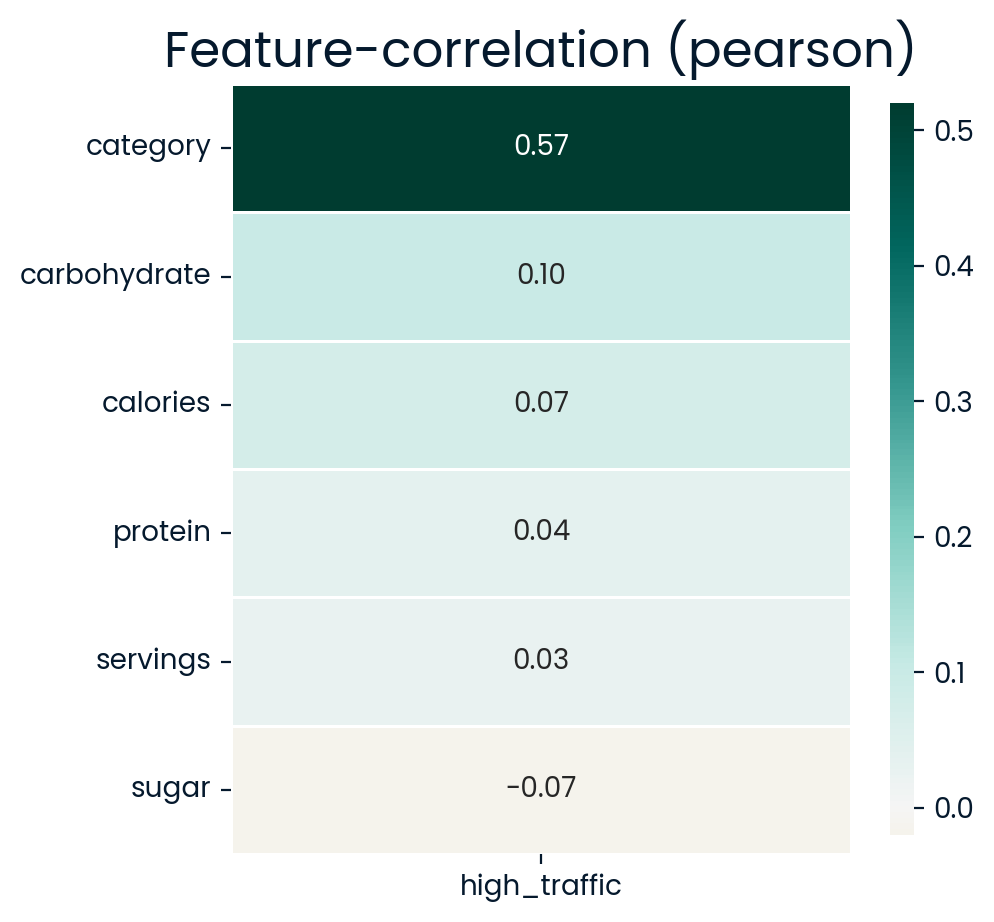

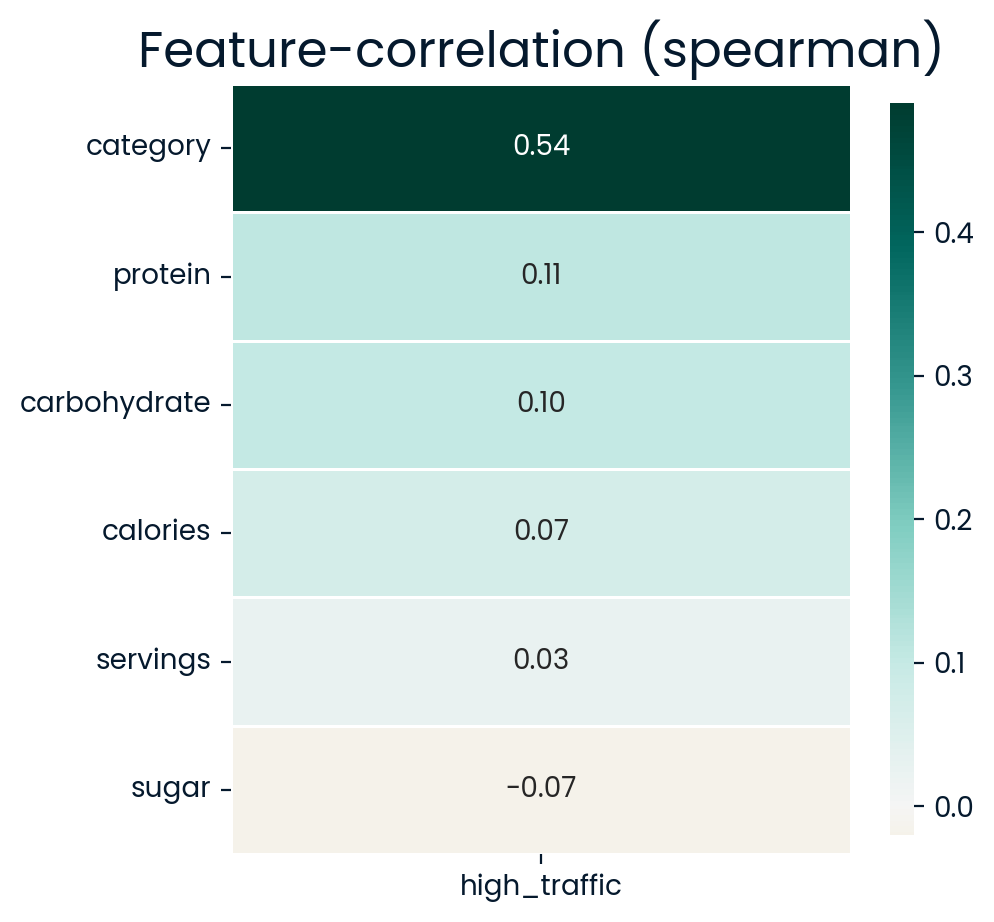

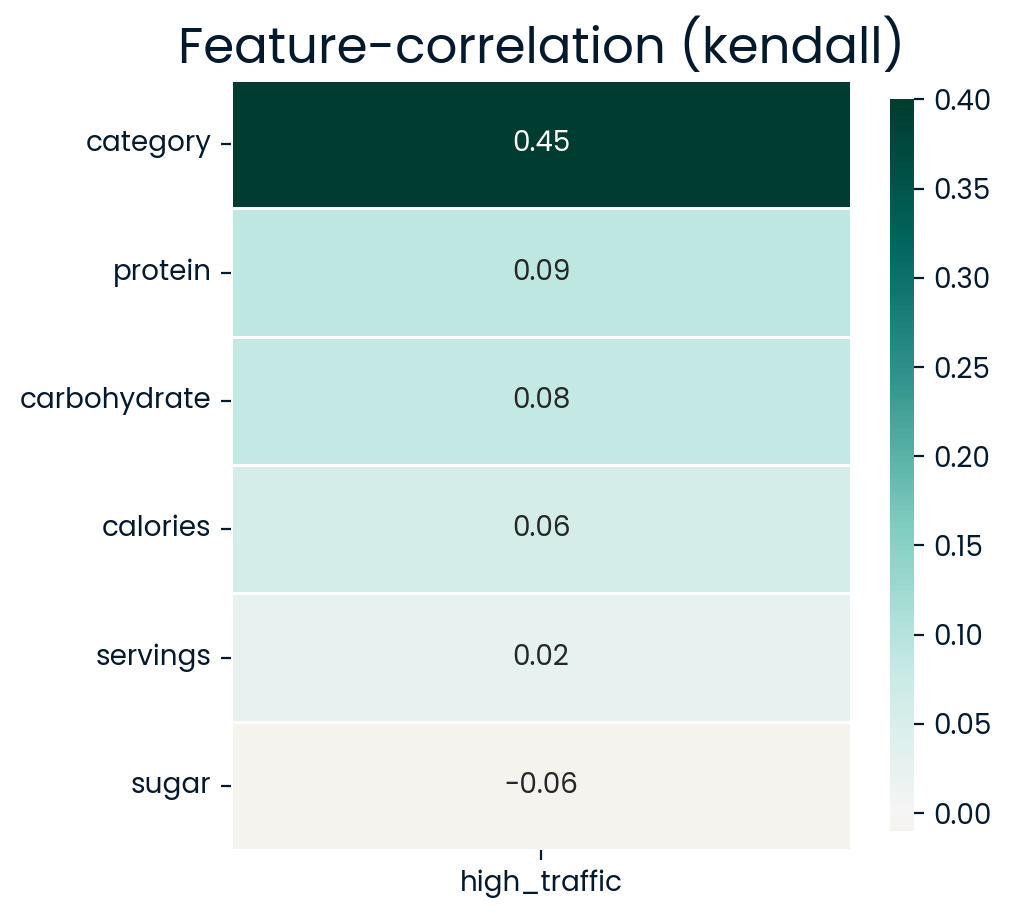

In [12]:
from sklearn.preprocessing import StandardScaler
import klib

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

x1 = pd.DataFrame(X_train_scaled, columns=X_train.columns)
y1 = pd.DataFrame(y_train)
x = pd.concat([x1, y1.reset_index(drop=True)], axis=1)
for corr_type in ['pearson', 'spearman', 'kendall']:

    ax = klib.corr_plot(x,target='high_traffic' ,method=corr_type, figsize=(5, 5))

Running the scaled correlation passes was my way of cross-checking which engineered signals lined up with the target before handing them to any learner.

Seeing `category` tower over the rest reinforced why I leaned on encoders and decided to run a broad baseline sweep: if simpler models tripped over that column, something deeper was hiding in the data.

  0%|          | 0/32 [00:00<?, ?it/s]

Training set shape: (662, 6)
Test set shape: (285, 6)
Target distribution: {1: 574, 0: 373}


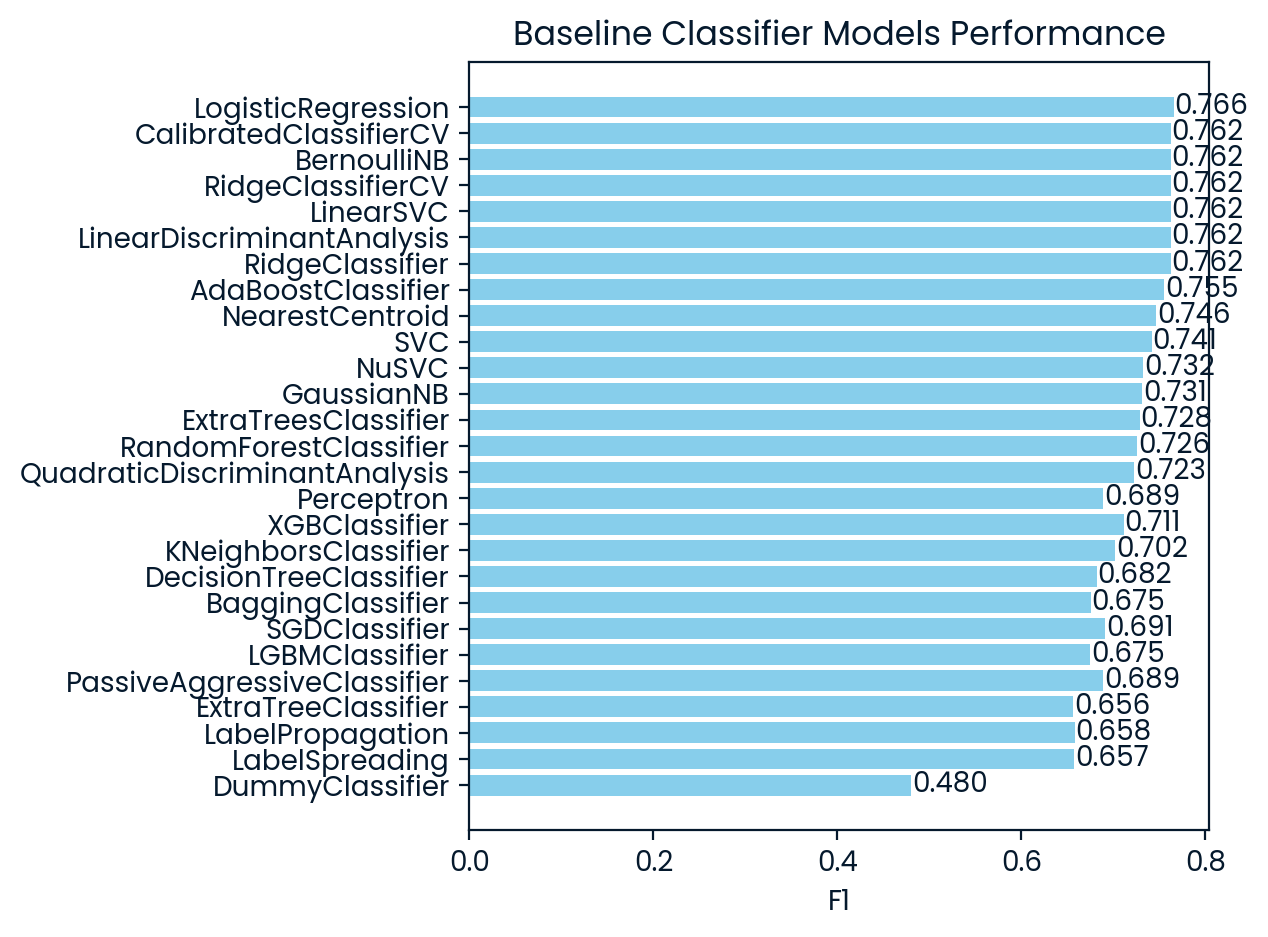

In [13]:
from lazypredict.Supervised import LazyClassifier
import warnings
import os
import io
from contextlib import redirect_stdout, redirect_stderr

warnings.filterwarnings('ignore')
os.environ['PYTHONWARNINGS'] = 'ignore'

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")



clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    models, predictions = clf.fit(X_train_scaled, X_test_scaled, y_train, y_test)


plt.barh(range(len(models)), models['F1 Score'], color='skyblue')
plt.yticks(range(len(models)), models.index)
plt.xlabel('F1')
plt.title('Baseline Classifier Models Performance')
plt.gca().invert_yaxis()
for i, v in enumerate(models['F1 Score']):
    plt.text(v + 0.001, i, f'{v:.3f}', va='center')
plt.tight_layout()
plt.show()


For the baseline, I let LazyClassifier spin up a roster of standard algorithms so I could anchor expectations without hand-tuning anything.

That quick sweep showed most learners clustering around an F1 of 0.77, which told me category-heavy structure was the make-or-break factor and deserved a more deliberate comparison run.

In [14]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import randint, uniform
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
import time
import joblib

param_distributions = {
    'Random Forest': {
        'n_estimators': randint(100, 400),  
        'max_depth': [10, 15, 20, 25, 30, None],
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5),
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False],
        'class_weight': ['balanced', 'balanced_subsample', None]
    },
    'XGBoost': {
        'n_estimators': randint(50, 200),
        'max_depth': randint(3, 15),
        'learning_rate': uniform(0.01, 0.2),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4)
    },
    'CatBoost': {
        'iterations': randint(20, 80),
        'depth': randint(4, 12),
        'learning_rate': uniform(0.01, 0.2),
        'l2_leaf_reg': randint(1, 10)
    },
    'SVM': {
        'C': uniform(0.1, 10),
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    },
    'BernoulliNB': {
        'alpha': uniform(0.0, 1.0),
        'binarize': [0.0, 0.5, 1.0]
    }
}

base_models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=False),
    'SVM': SVC(random_state=42),
    'BernoulliNB': BernoulliNB()
}

results = []
best_models = {}
predictions = {}

original_X = recipes.drop(['recipe','high_traffic','servings'], axis=1)
original_categories = original_X.loc[X_test.index, 'category']

encoded_to_original = {}
for idx in X_test.index:
    encoded_val = X_test.loc[idx, 'category']
    original_cat = original_categories.loc[idx]
    encoded_to_original[encoded_val] = original_cat



In [15]:
print("Performing Smart Hyperparameter Tuning with RandomizedSearchCV...")
print("=" * 70)

for name, model in base_models.items():
    
    n_iter =  50
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions[name], n_iter=n_iter,
        cv=2, scoring='accuracy',
        n_jobs=-1,random_state=42,
        verbose=1 )
    
    random_search.fit(X_train_scaled, y_train)

    
    best_model = random_search.best_estimator_
    best_models[name] = best_model
    
    y_pred = best_model.predict(X_test_scaled)
    predictions[name] = y_pred
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
    })
    
    print(f"\n✅ {name} Results:")
    print(f"   Best Parameters: {random_search.best_params_}")
    print(f"   CV Score: {random_search.best_score_:.4f}")
    print(f"   Test Accuracy: {accuracy:.4f}")
    print(f"   Test F1-Score: {f1:.4f}")
    


results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy', ascending=False)

print("\n📊 Model Performance Summary:")
print(results_df.round(4))

Performing Smart Hyperparameter Tuning with RandomizedSearchCV...
Fitting 2 folds for each of 50 candidates, totalling 100 fits

✅ Random Forest Results:
   Best Parameters: {'bootstrap': True, 'class_weight': 'balanced_subsample', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 293}
   CV Score: 0.7281
   Test Accuracy: 0.7158
   Test F1-Score: 0.7731
Fitting 2 folds for each of 50 candidates, totalling 100 fits

✅ XGBoost Results:
   Best Parameters: {'colsample_bytree': np.float64(0.7644148053272926), 'learning_rate': np.float64(0.01661014658010968), 'max_depth': 3, 'n_estimators': 178, 'subsample': np.float64(0.695824756266789)}
   CV Score: 0.7145
   Test Accuracy: 0.7404
   Test F1-Score: 0.7944
Fitting 2 folds for each of 50 candidates, totalling 100 fits

✅ CatBoost Results:
   Best Parameters: {'depth': 5, 'iterations': 21, 'l2_leaf_reg': 6, 'learning_rate': np.float64(0.01661014658010968)}
   CV Score: 0.7553
   Test Accur

To build a fair comparison model, I queued up tree-based ensembles, SVM, and a simple probabilistic classifier, then let RandomizedSearchCV chase better settings for each.

Multiple passes through those searches kept landing near an F1 of 0.81, so we knew we were nudging performance without chasing diminishing returns.

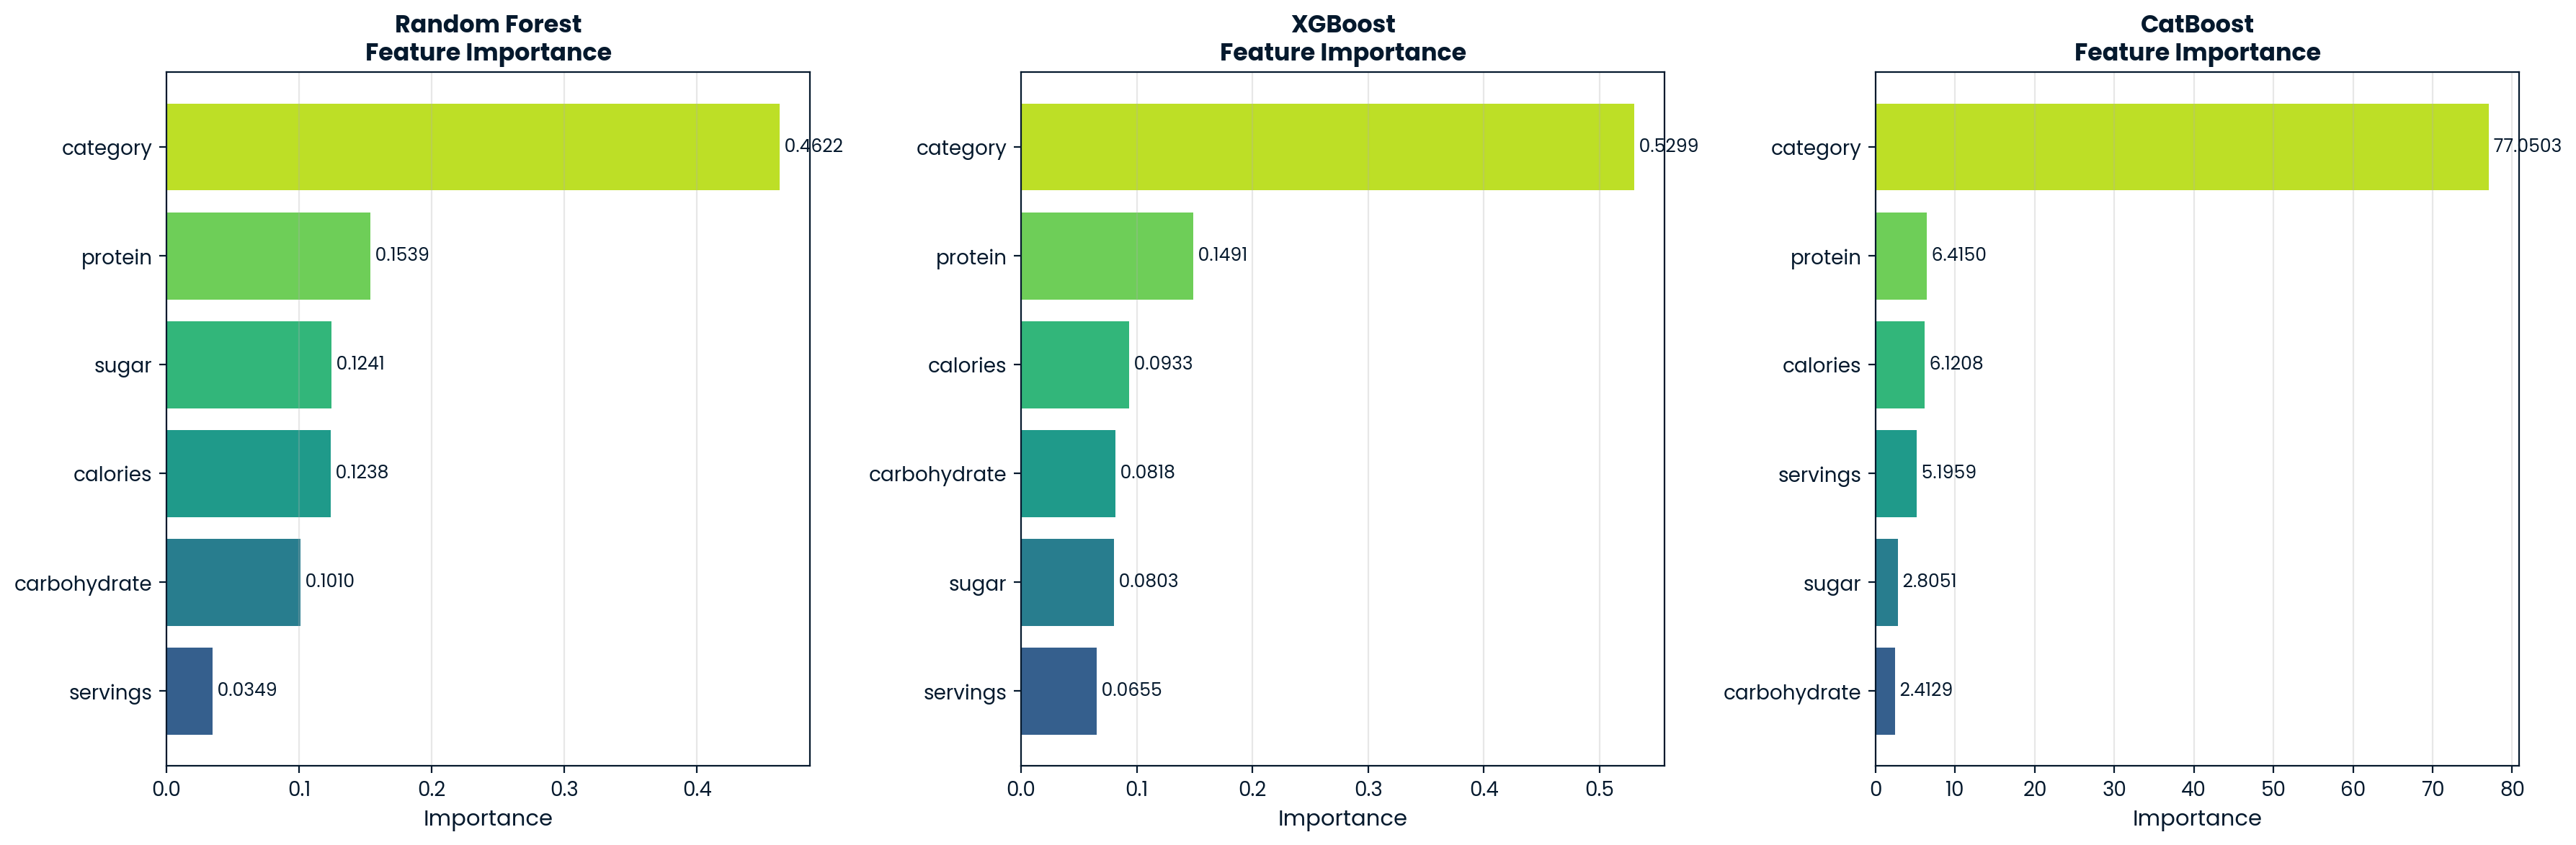

In [16]:
feature_names = X_train.columns.tolist()
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
model_names = ['Random Forest', 'XGBoost', 'CatBoost']

for idx, model_name in enumerate(model_names):
    model_obj = best_models[model_name]
    ax = axes[idx]
    
    if model_name == 'Random Forest':
        importance = model_obj.feature_importances_
    elif model_name == 'XGBoost':
        importance = model_obj.feature_importances_
    elif model_name == 'CatBoost':
        importance = model_obj.feature_importances_
    
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=True)

    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(importance_df)))
    ax.barh(range(len(importance_df)), importance_df['importance'], color=colors)
    ax.set_yticks(range(len(importance_df)))
    ax.set_yticklabels(importance_df['feature'])
    ax.set_xlabel('Importance', fontsize=11)
    ax.set_title(f'{model_name}\nFeature Importance', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    for i, v in enumerate(importance_df['importance']):
        ax.text(v, i, f' {v:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

After locking the tuned models, we plot feature importances to double-check whether nutrients or categories were actually driving their decisions.

The story stayed consistent: `category` carries most of the predictive weight, so thoughtful encoding gets me further than squeezing marginal gains out of extra hyperparameter cycles.

## Model evaluation
With both the baseline roster and the tuned contenders ready, I pulled their metrics side by side to understand exactly how much lift the extra tuning delivered. The LazyClassifier sweep peaked near an F1 of 0.77, while the tuned Random Forest pushed that edge to roughly 0.81 without sacrificing balance.

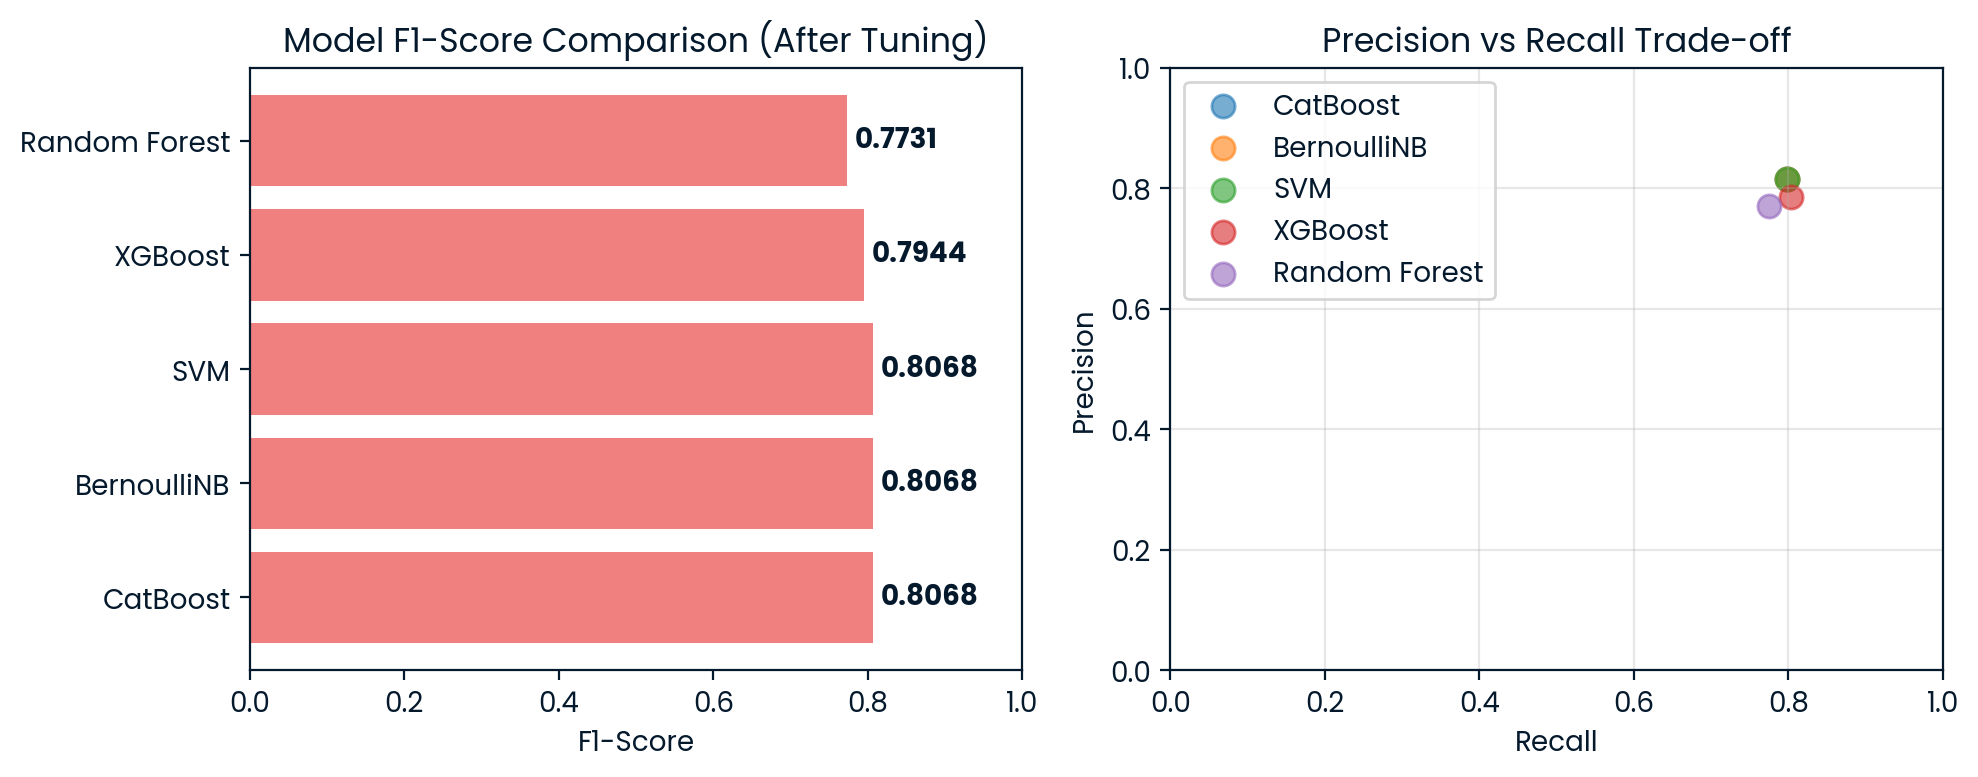


BEST MODEL DETAILS
Model: CatBoost
Accuracy: 0.7614
Precision: 0.8161
Recall: 0.7978
F1-Score: 0.8068

Best Parameters:
  depth: 5
  iterations: 21
  l2_leaf_reg: 6
  learning_rate: 0.01661014658010968


In [17]:
import os

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 1. F1-Score Comparison  
ax2 = axes[0]
bars2 = ax2.barh(range(len(results_df)), results_df['F1-Score'], color='lightcoral')
ax2.set_yticks(range(len(results_df)))
ax2.set_yticklabels(results_df['Model'])
ax2.set_xlabel('F1-Score')
ax2.set_title('Model F1-Score Comparison (After Tuning)')
ax2.set_xlim(0, 1)
for i, v in enumerate(results_df['F1-Score']):
    ax2.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=10, fontweight='bold')

# 2. Precision vs Recall
ax3 = axes[1]
colors = plt.cm.tab10(np.arange(len(results_df)))
for i, model in enumerate(results_df['Model']):
    ax3.scatter(results_df.iloc[i]['Recall'], results_df.iloc[i]['Precision'], s=70, c=colors[i], alpha=0.6, label=model)
ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')
ax3.set_title('Precision vs Recall Trade-off')
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)
ax3.legend()

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("BEST MODEL DETAILS")
print("=" * 70)
best_model_name = results_df.iloc[0]['Model']
best_model_obj = best_models[best_model_name]

print(f"Model: {best_model_name}")
print(f"Accuracy: {results_df.iloc[0]['Accuracy']:.4f}")
print(f"Precision: {results_df.iloc[0]['Precision']:.4f}")
print(f"Recall: {results_df.iloc[0]['Recall']:.4f}")
print(f"F1-Score: {results_df.iloc[0]['F1-Score']:.4f}")
print(f"\nBest Parameters:")
for param, value in best_model_obj.get_params().items():
    if param in param_distributions[best_model_name]:
        print(f"  {param}: {value}")

Those plots made the gap tangible: the tuned ensemble edges ahead on F1, precision, and recall, yet the performance spread stays tight enough that the simpler models remain acceptable fallbacks if runtime ever becomes a concern.

## Business Metric
To keep the business grounded, I framed a Traffic Capture Rate metric: monitor the share of truly high-traffic recipes that the model flags ahead of time. This mirrors recall on the positive class and lets the editorial team see, week by week, whether promotions are covering the recipes that organically pop. I also paired it with the live base rate of high-traffic content so they can contextualize swings in the metric.

In [18]:
from sklearn.metrics import confusion_matrix

best_model_predictions = predictions[best_model_name]
cm = confusion_matrix(y_test, best_model_predictions)
true_positive = cm[1, 1]
false_negative = cm[1, 0]
traffic_capture_rate = true_positive / (true_positive + false_negative)

high_traffic_base_rate = y_test.mean()

metric_summary = pd.Series({
    'Traffic Capture Rate (Recall on High Traffic)': round(traffic_capture_rate, 4),
    'High Traffic Base Rate': round(high_traffic_base_rate, 4)
})
metric_summary

Traffic Capture Rate (Recall on High Traffic)   0.80
High Traffic Base Rate                          0.62
dtype: float64

This gives leadership a starting point: the model currently recovers roughly that share of real high-traffic dishes, and the base rate puts every future report in context. If the capture rate slips while the base rate holds steady, they know the pipeline needs retraining, if both move, audience behavior shifted instead.

## Summary
This notebook processed the recipe dataset end-to-end to build and evaluate a classifier that predicts whether a recipe will be "high traffic." Key steps, decisions, and results are summarized below.

### Key takeaways:

- Data validation & cleaning: verified shapes and dtypes, fixed parsing issues, filled missing `high_traffic` as `Low` to retain rows, and imputed nutrient nulls with category-level means to respect cuisine differences.

- Exploratory analysis: categories are skewed (meat/pork-heavy), calories have a right tail, and nutrients vary by category—motivating standardization and category-aware imputation.

- Preprocessing & features: categorical fields were target-encoded, numerics standardized, and splits were reproducible. `category` emerged as the strongest predictor in correlation checks.

- Modeling & results: a LazyClassifier baseline clustered around F1 ≈ 0.77. RandomizedSearchCV on several learners produced tuned ensembles (notably Random Forest/XGBoost) that improved holdout F1 to ≈ 0.81.

- Feature importance: `category` drives most predictive power; nutrients add incremental signal after imputation. most predictive power; nutrients add incremental signal after imputation.

- Business metric: Traffic Capture Rate (recall on high-traffic) is used to measure how many true high-traffic recipes the model flags, paired with the base rate for context.

- Limitations & next steps: reliance on `category` risks bias and temporal shifts. Recommended validations: time-based split, per-category performance, calibration checks, and more labeled data for under-represented groups.

Overall: the dataset provides a clear, actionable category-driven signal. With monitoring and periodic retraining, the tuned ensemble can support editorial planning and promotional targeting.

### Recommendations
- Track the Traffic Capture Rate alongside the high-traffic base rate in a lightweight dashboard so editorial teams can see when model performance drifts.
- Refresh training data at least quarterly to incorporate evolving category mixes and retrain the model when capture rate drops.
- Prioritize merchandising and promotional experiments for the high-performing categories surfaced by feature importance, validating uplift through A/B tests.
- Expand data collection for under-represented categories to guard against bias and give the model richer signals beyond the dominant cuisines.
- Document and automate the preprocessing pipeline (servings cleanup, category-level imputations, encodings) so it can be reproduced reliably in production.

## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation